In [1]:
import sys
import os

project_root = r"C:\Users\aimje\OneDrive\Documents\Other projects\early_detection_lms"
sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.features.feature_engineer import FeatureEngineer
from src.utils.config import *

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete")

✓ Setup complete


# 02 - Feature Engineering

Transform raw LMS log data into ML-ready features.

## Objectives:
1. Load raw LMS data
2. Create student-level features
3. Analyze feature distributions
4. Save features for model training

In [2]:
# Load the raw data we saved in notebook 01
data_path = os.path.join(SYNTHETIC_DATA_DIR, 'lms_logs_1000_students_90_days.csv')

print(f"Loading data from: {data_path}")
raw_data = pd.read_csv(data_path)

print(f"\n✓ Data loaded successfully")
print(f"Total log entries: {len(raw_data):,}")
print(f"Unique students: {raw_data['student_id'].nunique()}")

Loading data from: C:\Users\aimje\OneDrive\Documents\Other projects\early_detection_lms\data\synthetic\lms_logs_1000_students_90_days.csv

✓ Data loaded successfully
Total log entries: 69,121
Unique students: 1000


## Step 1: Create Features

In [3]:
# Initialize feature engineer
engineer = FeatureEngineer(min_days_active=5)

# Create features
print("Creating features from raw log data...")
print("="*60)
features = engineer.create_features(raw_data)

print("\n" + "="*60)
print("Feature Creation Complete")
print("="*60)
print(f"Number of students with features: {len(features)}")
print(f"Number of features per student: {len(features.columns) - 2}")
print(f"\nFeature columns:")
for col in features.columns:
    if col not in ['student_id', 'at_risk']:
        print(f"  - {col}")

Creating features from raw log data...
Creating features from 69121 log entries...
Processing 1000 students...
Created 1000 feature vectors with 17 features each
At-risk students: 237 (23.7%)

Feature Creation Complete
Number of students with features: 1000
Number of features per student: 17

Feature columns:
  - total_logins
  - avg_session_duration
  - total_page_views
  - total_forum_posts
  - total_assignments
  - avg_quiz_score
  - total_video_time
  - total_downloads
  - days_active
  - engagement_trend
  - login_consistency
  - session_consistency
  - quiz_improvement
  - pages_per_session
  - posts_per_login
  - login_rate
  - assignment_rate


## Step 2: Explore Feature Statistics

In [4]:
# Display sample features
print("Sample features (first 5 students):")
print(features.head())

print("\n" + "="*60)
print("Feature Statistics:")
print("="*60)
print(features.describe())

print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"Normal students: {(features['at_risk'] == 0).sum()} ({(features['at_risk'] == 0).mean()*100:.1f}%)")
print(f"At-risk students: {(features['at_risk'] == 1).sum()} ({(features['at_risk'] == 1).mean()*100:.1f}%)")

Sample features (first 5 students):
  student_id  at_risk  total_logins  avg_session_duration  total_page_views  \
0   STU_0001        0           198             46.741852              1896   
1   STU_0002        0           251             37.081181              2007   
2   STU_0003        0           228             40.439831              1898   
3   STU_0004        1           131             12.081182               362   
4   STU_0005        0           218             44.448676              2026   

   total_forum_posts  total_assignments  avg_quiz_score  total_video_time  \
0                140                 62       78.670621       1881.973560   
1                155                 67       78.340972       1573.565378   
2                141                 69       78.278440       1339.714625   
3                 24                 18       54.863061       1280.991265   
4                149                 66       80.582671       1250.084298   

   total_downloads  days_a

## Step 3: Feature Distributions by Risk Level

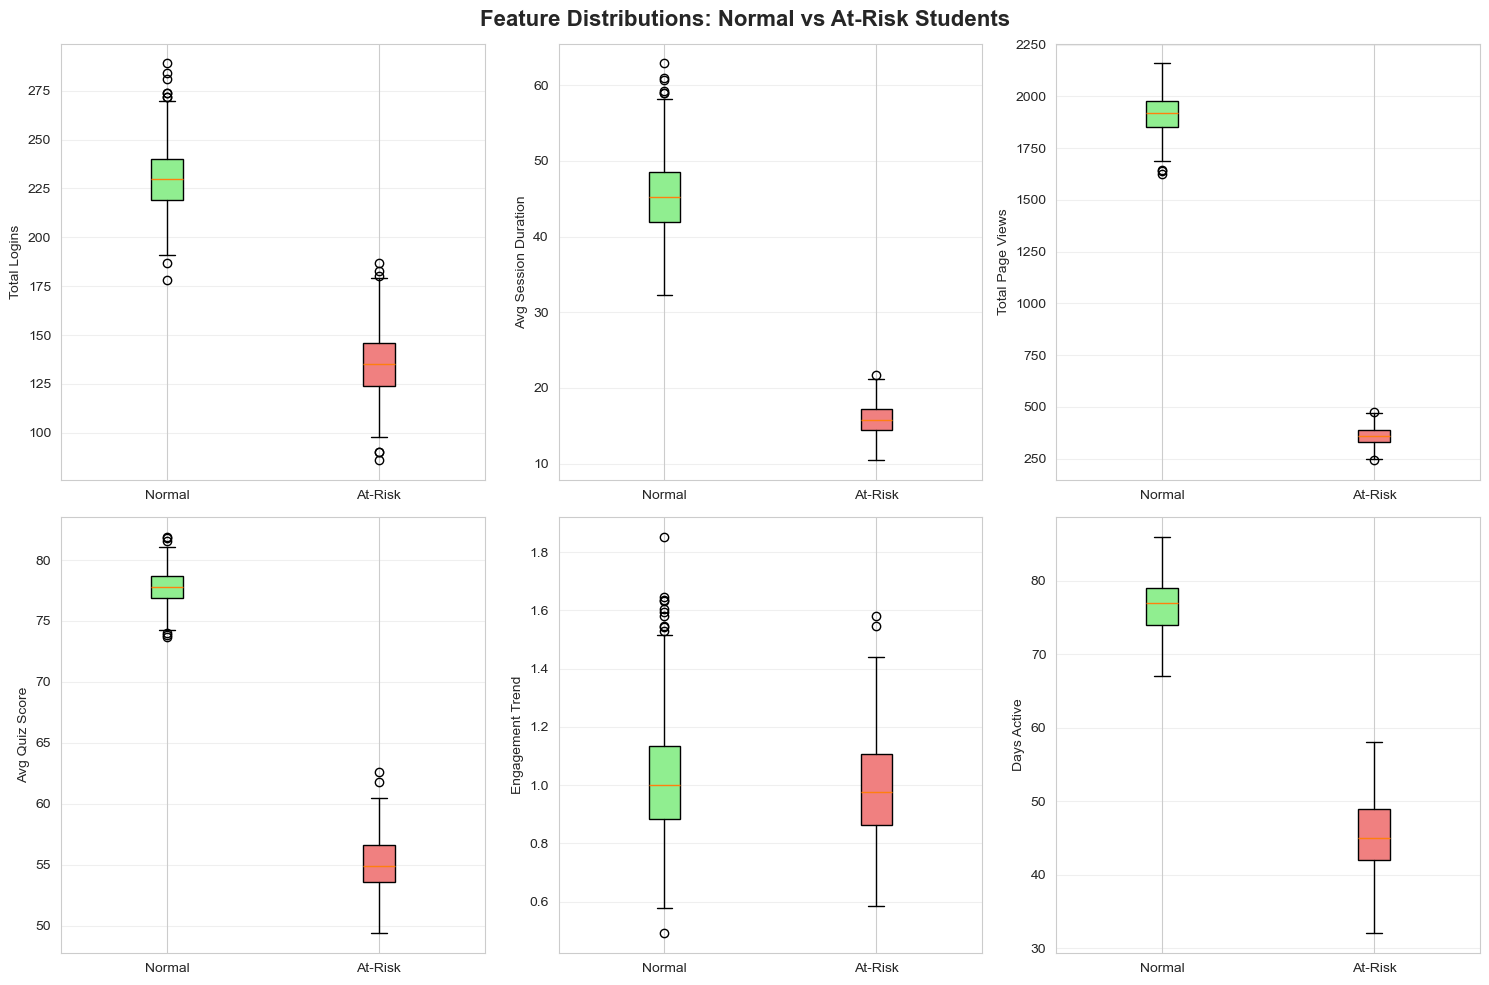

In [5]:
# Select key features to visualize
key_features = ['total_logins', 'avg_session_duration', 'total_page_views', 
                'avg_quiz_score', 'engagement_trend', 'days_active']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, feature in enumerate(key_features):
    ax = axes[idx // 3, idx % 3]
    
    # Separate by risk level
    normal = features[features['at_risk'] == 0][feature]
    at_risk = features[features['at_risk'] == 1][feature]
    
    # Box plots
    box_data = [normal, at_risk]
    bp = ax.boxplot(box_data, labels=['Normal', 'At-Risk'], patch_artist=True)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel(feature.replace('_', ' ').title())
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Feature Distributions: Normal vs At-Risk Students', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4: Feature Correlations

Feature Correlations with At-Risk Status:
at_risk                 1.000000
quiz_improvement        0.041831
login_consistency       0.016368
login_rate             -0.009055
engagement_trend       -0.045654
total_video_time       -0.823699
session_consistency    -0.901963
total_downloads        -0.911862
total_logins           -0.927690
avg_session_duration   -0.941432
posts_per_login        -0.963601
days_active            -0.963961
assignment_rate        -0.965203
total_forum_posts      -0.977355
total_assignments      -0.979866
pages_per_session      -0.983660
avg_quiz_score         -0.986398
Name: at_risk, dtype: float64


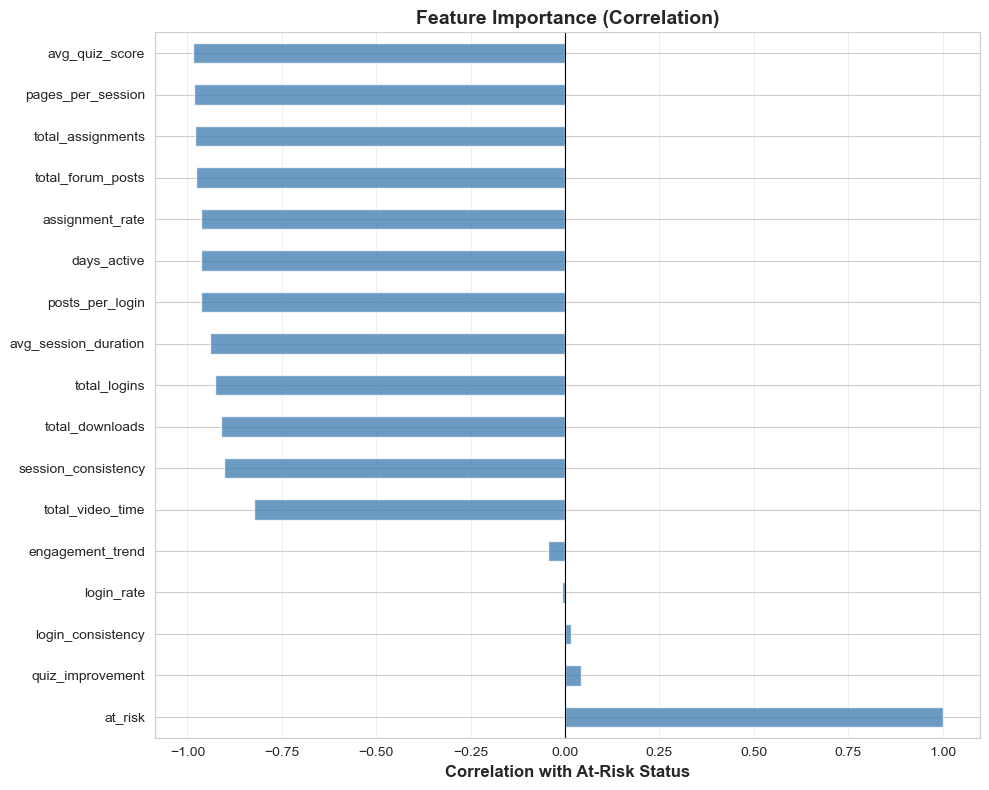

In [6]:
# Calculate correlation with target variable
feature_cols = [col for col in features.columns if col not in ['student_id', 'at_risk']]
correlations = features[feature_cols + ['at_risk']].corr()['at_risk'].sort_values(ascending=False)

print("Feature Correlations with At-Risk Status:")
print("="*60)
print(correlations[:-1])  # Exclude at_risk itself

# Visualize
plt.figure(figsize=(10, 8))
correlations[:-1].plot(kind='barh', color='steelblue', alpha=0.8)
plt.xlabel('Correlation with At-Risk Status', fontsize=12, fontweight='bold')
plt.title('Feature Importance (Correlation)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Step 5: Save Features

In [7]:
# Save features for model training
filepath = engineer.save_features(features, filename='student_features_1000.csv')

print(f"\n✓ Features saved successfully!")
print(f"File location: {filepath}")
print(f"\nNext step: Run notebook 03_model_training.ipynb")

Features saved to: C:\Users\aimje\OneDrive\Documents\Other projects\early_detection_lms\data\processed\student_features_1000.csv

✓ Features saved successfully!
File location: C:\Users\aimje\OneDrive\Documents\Other projects\early_detection_lms\data\processed\student_features_1000.csv

Next step: Run notebook 03_model_training.ipynb
